In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device availabel: ", device)

Device availabel:  cuda


In [3]:
root_dir = "/kaggle/input/eye-diseases-classification/dataset"

data = []

for label in os.listdir(root_dir):
    label_path = os.path.join(root_dir, label)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            data.append({"label": label, "path": img_path})

df = pd.DataFrame(data)

df = df.sample(frac=1).reset_index(drop=True)

In [4]:
df.head()

,label,path
0,diabetic_retinopathy,/kaggle/input/eye-diseases-classification/data...
1,cataract,/kaggle/input/eye-diseases-classification/data...
2,normal,/kaggle/input/eye-diseases-classification/data...
3,diabetic_retinopathy,/kaggle/input/eye-diseases-classification/data...
4,diabetic_retinopathy,/kaggle/input/eye-diseases-classification/data...


In [5]:
df['label'].value_counts()

label
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

In [6]:
fig=px.pie(data_frame=df, names='label')
fig.show()

In [7]:
import cv2
import matplotlib.pyplot as plt

def plot_img(idx):
    image_path=df.iloc[idx][1]
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    if img is None:
        print("Error: Image not found at", image_path)
        return

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"label: {df.iloc[idx][0]}")
    plt.axis('off')
    plt.show()


/tmp/ipykernel_47/1793765299.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_47/1793765299.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



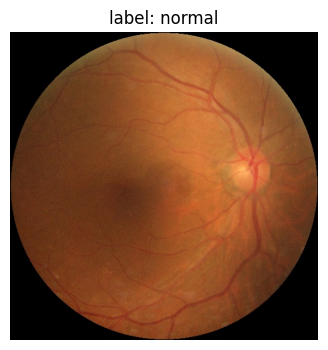

In [8]:
plot_img(2)

In [9]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(2952, 2)
(633, 2)
(632, 2)


In [10]:
label_encoder = LabelEncoder()
label_encoder.fit(df["label"])

LabelEncoder()

In [11]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe=dataframe
        self.transform=transform
        self.labels = torch.tensor(label_encoder.transform(dataframe["label"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self,idx):
        img_path = self.dataframe.iloc[idx,1]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)
            
        return image, label

In [13]:
train_df = CustomImageDataset(train, transform)
val_df = CustomImageDataset(val, transform)
test_df = CustomImageDataset(test, transform)

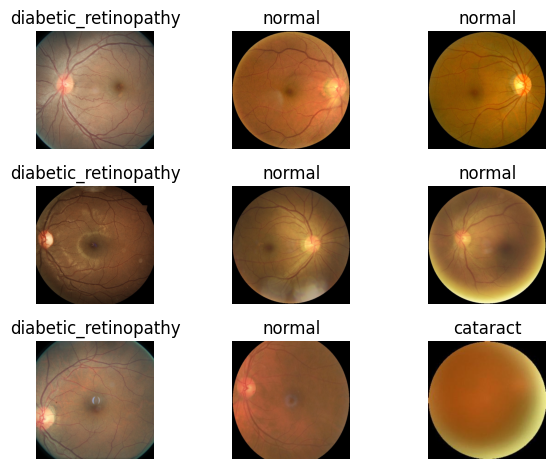

In [14]:
nrows=3
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

for row in range(nrows):
    for col in range(ncols):
        sample=df.sample(n=1).iloc[0]
        label=sample.iloc[0]
        path=sample.iloc[1]
        image=Image.open(path).convert("RGB")
        axs[row,col].imshow(image)
        axs[row,col].axis("off")
        axs[row,col].set_title(label)

plt.tight_layout()
plt.show()

In [15]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [16]:
train_loader = DataLoader(train_df, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_df, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_df, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

weights = EfficientNet_V2_S_Weights.DEFAULT
efficientnet_model = efficientnet_v2_s(weights=weights)



Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 231MB/s]


In [18]:
print(efficientnet_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
num_classes = 4  
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, num_classes)

In [21]:
class Net(nn.Module):
    def __init__(self, efficientnet_model):
        super().__init__()
        self.model=efficientnet_model

    def forward(self,x):
        x=self.model(x)
        return x

In [22]:
num_blocks = len(list(efficientnet_model.parameters()))
freeze_until = num_blocks // 2

for param_idx, param in enumerate(efficientnet_model.parameters()):
    if param_idx < freeze_until:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [23]:
model = Net(efficientnet_model).to(device)

In [24]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

In [27]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

epochs = 10

for epoch in range(epochs):
    total_loss_train=0
    total_loss_val=0
    total_acc_train=0
    total_acc_val=0

    for data in train_loader:
        inputs, labels = data

        prediction = model(inputs)
        
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()
        
        acc = (torch.argmax(prediction, axis=1) == labels).sum().item()
        total_acc_train +=acc
        
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
    
            prediction = model(inputs)
            
            batch_loss = criterion(prediction, labels)
            total_loss_val += batch_loss.item()
            
            acc = (torch.argmax(prediction, axis=1) == labels).sum().item()
            total_acc_val +=acc

    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_val_plot.append(round(total_loss_val/1000,4))
    total_acc_train_plot.append(round(total_acc_train/train_df.__len__()*100,4))
    total_acc_val_plot.append(round(total_acc_val/val_df.__len__()*100,4))

    print(f'''Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy {round(total_acc_train/train_df.__len__() * 100, 4)}
    Validation Loss: {round(total_loss_val/1000, 4)} Validation Accuracy: {round(total_acc_val/val_df.__len__() * 100, 4)}''')

    print("="*25)

Epoch no. 1 Train Loss: 0.0116 Train Accuracy 98.1707
    Validation Loss: 0.0131 Validation Accuracy: 91.7722
Epoch no. 2 Train Loss: 0.0101 Train Accuracy 98.5095
    Validation Loss: 0.0112 Validation Accuracy: 91.7722
Epoch no. 3 Train Loss: 0.0074 Train Accuracy 98.7466
    Validation Loss: 0.0114 Validation Accuracy: 91.6139
Epoch no. 4 Train Loss: 0.0083 Train Accuracy 98.645
    Validation Loss: 0.009 Validation Accuracy: 93.1962
Epoch no. 5 Train Loss: 0.0067 Train Accuracy 98.9837
    Validation Loss: 0.0118 Validation Accuracy: 91.7722
Epoch no. 6 Train Loss: 0.0052 Train Accuracy 99.0515
    Validation Loss: 0.0128 Validation Accuracy: 91.2975
Epoch no. 7 Train Loss: 0.004 Train Accuracy 99.2886
    Validation Loss: 0.0151 Validation Accuracy: 91.2975
Epoch no. 8 Train Loss: 0.0047 Train Accuracy 99.1192
    Validation Loss: 0.0127 Validation Accuracy: 90.981
Epoch no. 9 Train Loss: 0.0048 Train Accuracy 99.1192
    Validation Loss: 0.0132 Validation Accuracy: 91.9304
Epoch

In [28]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in test_loader:
        inputs, labels = data

        prediction = model(inputs)
        
        batch_loss = criterion(prediction, labels)
        total_loss_test += batch_loss.item()
        
        acc = (torch.argmax(prediction, axis=1) == labels).sum().item()
        total_acc_test +=acc

print(f"Acc: {round(total_acc_test/test_df.__len__()*100,4)}")

Acc: 91.7852
